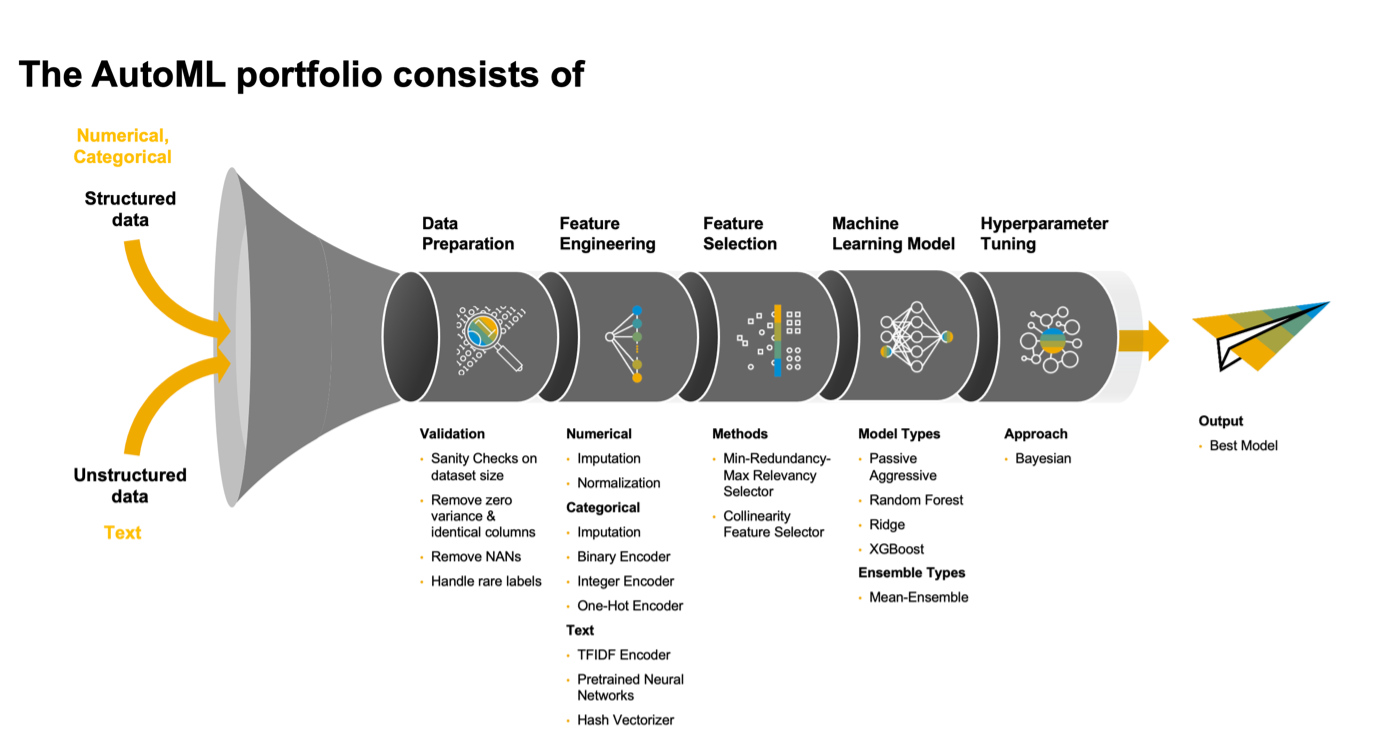

# Tutorial 1: Basics

[Tutorial link in official repo](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb)


In this tutorial you will learn how to:
* run LightAutoML training on tabular data
* obtain feature importances and reports
* configure resource usage in LightAutoML

Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
!pip install -U lightautoml > None

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.8.1 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.8.1 which is incompatible.


### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

import requests

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [3]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

In [4]:
DATASET_DIR = 'data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
DATASET_FULLNAME

'data/sampled_app_train.csv'

In [7]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [8]:
data = pd.read_csv('data/sampled_app_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [9]:
data.shape

(10000, 122)

### 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [10]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## 1. Task definition

### 1.1. Task type


On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [11]:
task = Task('binary')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [12]:
roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

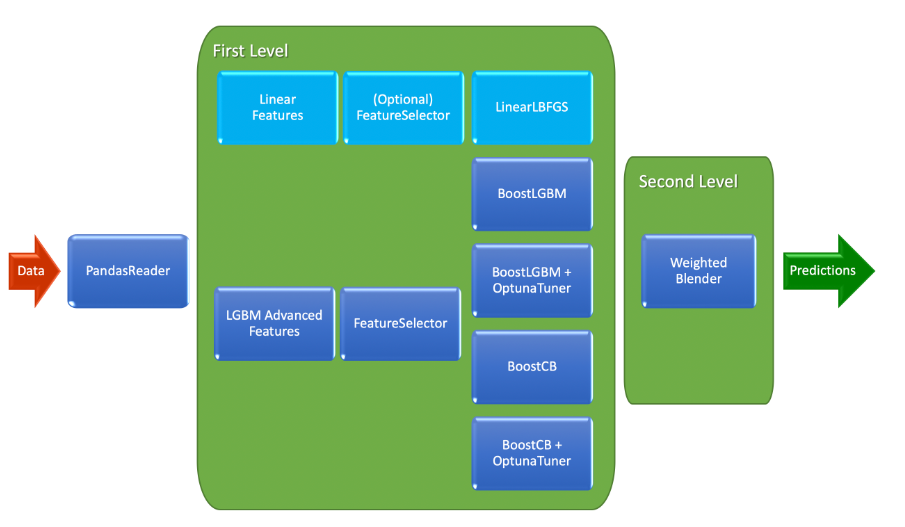

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [13]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

## 2. AutoML training

To run autoML training use fit_predict method:

- `train_data` - Dataset to train.
- `roles` - Roles dict.

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [14]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles)

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: binary

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 300.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (8000, 122)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 292.70 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], '

CPU times: user 5min 33s, sys: 15.4 s, total: 5min 48s
Wall time: 3min 33s


## 3. Prediction on holdout and model evaluation

In [15]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.08599623],
       [0.0863232 ],
       [0.03026347],
       ...,
       [0.06260456],
       [0.03790615],
       [0.20376381]], dtype=float32)
Shape = (2000, 1)
CPU times: user 1.17 s, sys: 11.8 ms, total: 1.18 s
Wall time: 841 ms


In [16]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7462128049129204
HOLDOUT score: 0.7369870923913042


## 4. Model analysis

### 4.1. Reports

You can obtain the description of the resulting pipeline:

Also for this purposes LightAutoML have ReportDeco, use it to build reports:

In [17]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [18]:
%%time
oof_pred = automl_rd.fit_predict(tr_data, roles = roles)

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: binary

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 300.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (8000, 122)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 297.81 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], '

CPU times: user 5min 47s, sys: 16.6 s, total: 6min 4s
Wall time: 3min 33s


So the report is available in tabularAutoML_model_report folder

In [19]:
!ls tabularAutoML_model_report

feature_importance.png		  valid_pr_curve.png
lama_interactive_report.html	  valid_preds_distribution_by_bins.png
valid_distribution_of_logits.png  valid_roc_curve.png
valid_pie_f1_metric.png


In [20]:
%%time

te_pred = automl_rd.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.08266112],
       [0.08956888],
       [0.03028981],
       ...,
       [0.06265474],
       [0.03811339],
       [0.20322171]], dtype=float32)
Shape = (2000, 1)
CPU times: user 3.22 s, sys: 71.7 ms, total: 3.29 s
Wall time: 2.96 s


In [21]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7470491715102158
HOLDOUT score: 0.7379449728260871


### 4.2 Feature importances calculation 


For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 280 ms, sys: 5.95 ms, total: 286 ms
Wall time: 342 ms


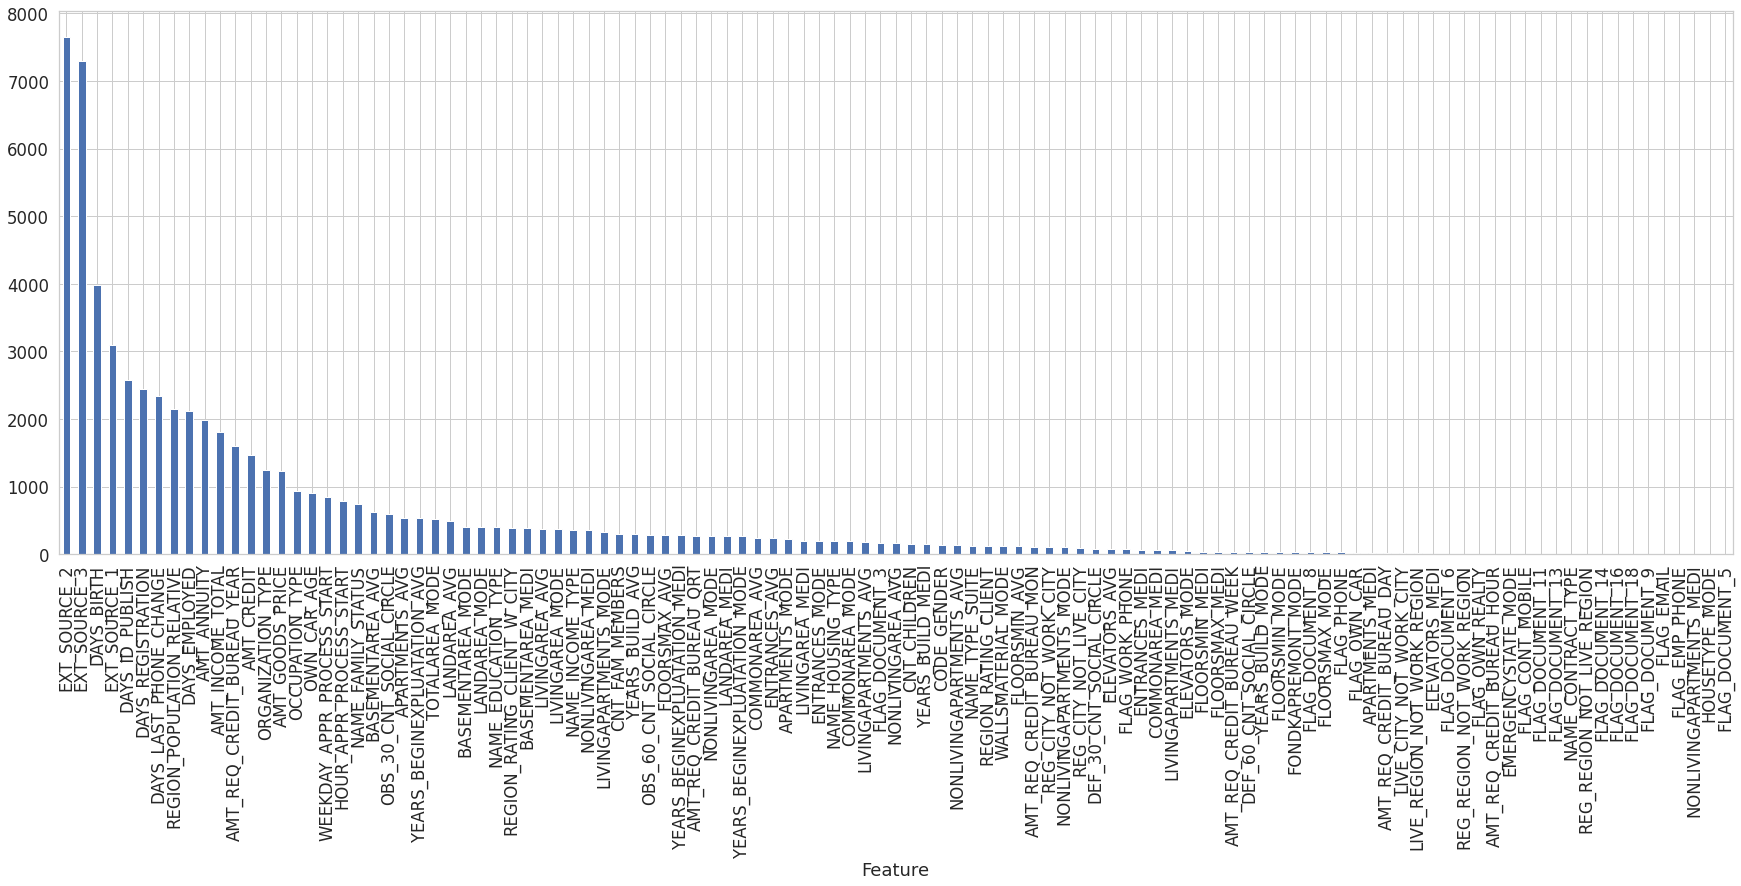

In [22]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [23]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

INFO3:lightautoml.automl.presets.utils:LightAutoML ts master used 109 feats
INFO3:lightautoml.automl.presets.utils:1/109 Calculated score for REGION_RATING_CLIENT: -0.0013655
INFO3:lightautoml.automl.presets.utils:2/109 Calculated score for LIVE_CITY_NOT_WORK_CITY: -0.0000102
INFO3:lightautoml.automl.presets.utils:3/109 Calculated score for ENTRANCES_MODE: -0.0004178
INFO3:lightautoml.automl.presets.utils:4/109 Calculated score for LIVE_REGION_NOT_WORK_REGION: 0.0002649
INFO3:lightautoml.automl.presets.utils:5/109 Calculated score for DAYS_BIRTH: 0.0006793
INFO3:lightautoml.automl.presets.utils:6/109 Calculated score for COMMONAREA_MEDI: 0.0002038
INFO3:lightautoml.automl.presets.utils:7/109 Calculated score for NAME_HOUSING_TYPE: 0.0022622
INFO3:lightautoml.automl.presets.utils:8/109 Calculated score for OBS_60_CNT_SOCIAL_CIRCLE: -0.0009918
INFO3:lightautoml.automl.presets.utils:9/109 Calculated score for FLAG_CONT_MOBILE: 0.0001495
INFO3:lightautoml.automl.presets.utils:10/109 Calcul

CPU times: user 2min 9s, sys: 1.07 s, total: 2min 10s
Wall time: 1min 34s


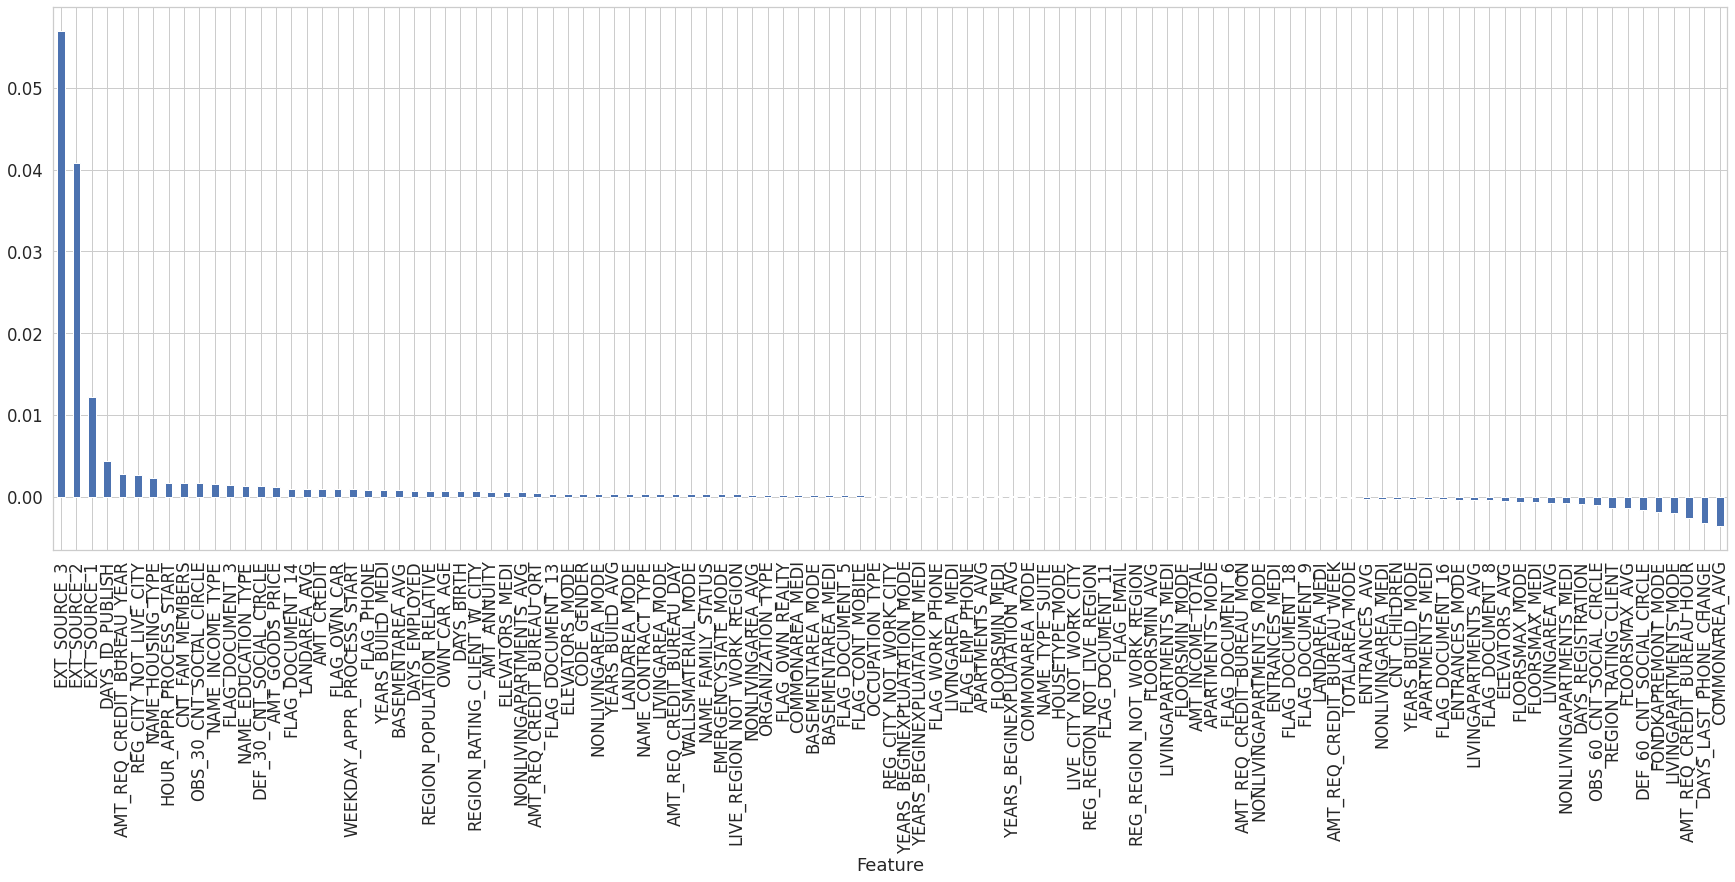

In [24]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

### Bonus: where is the automatic report?


As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output kaggle folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

## 5. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage


Using `TabularAutoML` we spent only 31 second to build the model with setup `TIMEOUT` equal to 5 minutes. To spend (almost) all the `TIMEOUT` we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API:

In [25]:
utilized_automl = TabularUtilizedAutoML(
    task = task, 
    timeout = 600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [26]:
%%time 

oof_pred = utilized_automl.fit_predict(tr_data, roles = roles)

INFO:lightautoml.addons.utilization.utilization:Start automl utilizator with listed constraints:
INFO:lightautoml.addons.utilization.utilization:- time: 600.00 seconds
INFO:lightautoml.addons.utilization.utilization:- CPU: 4 cores
INFO:lightautoml.addons.utilization.utilization:- memory: 16 GB

INFO:lightautoml.addons.utilization.utilization:If one preset completes earlier, next preset configuration will be started

INFO:lightautoml.addons.utilization.utilization:==================================================
INFO:lightautoml.addons.utilization.utilization:Start 0 automl preset configuration:
INFO:lightautoml.addons.utilization.utilization:conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
INFO3:lightautoml.addons.utilization.utilization:Found reader_params in kwargs, need to combine
INFO3:lightautoml.addons.utilization.utilization:Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state':

CPU times: user 11min 22s, sys: 33.2 s, total: 11min 55s
Wall time: 6min 43s


In [27]:
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.04465068],
       [0.02110032],
       [0.02750438],
       ...,
       [0.03813341],
       [0.21066347],
       [0.10517158]], dtype=float32)
Shape = (8000, 1)


Prediction on holdout and metric calculation

In [28]:
%%time

te_pred = utilized_automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.07701155],
       [0.08025265],
       [0.03310107],
       ...,
       [0.07568233],
       [0.04564936],
       [0.19988424]], dtype=float32)
Shape = (2000, 1)
CPU times: user 2 s, sys: 14.9 ms, total: 2.02 s
Wall time: 1.43 s


In [29]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7502554914993137
HOLDOUT score: 0.7324864130434783


## Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)